In [2]:
import keras
import tensorflow as tf

In [3]:
import os
from os.path import join
import json
import random
import itertools
import re
import datetime
# import cairocffi as cairo
# import editdistance
import numpy as np
from scipy import ndimage
import pylab
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model, load_model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD
from keras.utils.data_utils import get_file
from keras.preprocessing import image
import keras.callbacks
import cv2

In [4]:
from tqdm import tqdm

In [5]:
sess = tf.Session()
K.set_session(sess)

# Get alphabet

In [11]:
from collections import Counter
def get_counter(dirpath, tag):
    dirname = os.path.basename(dirpath)
    ann_dirpath = join(dirpath, '')
    
    letters = ''
    lens = []
    for filename in tqdm(os.listdir(ann_dirpath)):
        if not('.png' in str(filename)) | ('.jpg' in str(filename)):
            continue
#         print(filename)
#         print(letters)
#         json_filepath = join(ann_dirpath, filename)
        
#         ann = json.load(open(json_filepath, 'r'))

#         tags = ann['tags']
#         if tags[0]['name'] == tag:
#             description = ann['description']
#             lens.append(len(description))
        lens.append(len(filename[:-4]))
        letters += filename[:-4]
    
    print('Max plate length in "%s":' % dirname, max(Counter(lens).keys()))
    return Counter(letters)
c_val = get_counter('./ctc_loss_images/val', 'val')
c_train = get_counter('./ctc_loss_images/train', 'train')
c_test = get_counter('./ctc_loss_images/test', 'train')
letters_train = set(c_train.keys())
letters_val = set(c_val.keys())
letters_test = set(c_test.keys())
if letters_train == letters_val:
    print('Letters in train and val do match')

if letters_test == letters_val:
    print('Letters in test and val do match')
    
if letters_test == letters_train:
    print('Letters in test and train do match')
    
print(len(letters_train), len(letters_val), len(letters_val | letters_train | letters_test))
letters = sorted(list(letters_train))
print('Letters:', ' '.join(letters))

100%|██████████| 113/113 [00:00<00:00, 94394.81it/s]

Max plate length in "val": 5
Max plate length in "train": 5
Max plate length in "test": 5
Letters in train and val do match
Letters in test and val do match
Letters in test and train do match
19 19 19
Letters: 2 3 4 5 6 7 8 b c d e f g m n p w x y


# Input data generator

In [55]:
def labels_to_text(labels):
    return ''.join(list(map(lambda x: letters[int(x)], labels)))

def text_to_labels(text):
    return list(map(lambda x: letters.index(x), text))

def is_valid_str(s):
    for ch in s:
        if not ch in letters:
            return False
    return True

class TextImageGenerator:
    
    def __init__(self, 
                 dirpath,
                 tag,
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=5):
        
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        img_dirpath = join(dirpath, '')
#         ann_dirpath = join(dirpath, '')
        self.samples = []
        for filename in tqdm(os.listdir(img_dirpath)):
            name, ext = os.path.splitext(filename)
            if ext in ['.png', '.jpg']:
                
                
                img_filepath = join(img_dirpath, filename)
#                 json_filepath = join(ann_dirpath, name + '.png.json')
#                 print(img_filepath)
#                 print(json_filepath)
#                 ann = json.load(open(json_filepath, 'r'))
                description = filename[:-4]
#                 tags = ann['tags']
#                 print(tags[0]['name'])
#                 if tags[0]['name'] == tag:
#                     continue
#                 if is_valid_str(description):
#                     print('here')
                self.samples.append([img_filepath, description])
        
        
        self.n = len(self.samples)
        self.indexes = list(range(self.n))
        self.cur_index = 0
        
    def build_data(self):
        self.imgs = np.zeros((self.n, self.img_h, self.img_w))
        self.texts = []
        print(self.n)
        for i, (img_filepath, text) in tqdm(enumerate(self.samples)):
            
            img = cv2.imread(img_filepath)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = img.astype(np.float32)
            img /= 255
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            self.imgs[i, :, :] = img
            self.texts.append(text)
        
    def get_output_size(self):
        return len(letters) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            random.shuffle(self.indexes)
        return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            # width and height are backwards from typical Keras convention
            # because width is the time dimension when it gets fed into the RNN
            if K.image_data_format() == 'channels_first':
                X_data = np.ones([self.batch_size, 1, self.img_w, self.img_h])
            else:
                X_data = np.ones([self.batch_size, self.img_w, self.img_h, 1])
            
            Y_data = np.ones([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
#             print('input_length_jth', input_length)
            label_length = np.zeros((self.batch_size, 1))
#             print('label_length_jth',label_length)
            source_str = []
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                if K.image_data_format() == 'channels_first':
                    img = np.expand_dims(img, 0)
                else:
                    img = np.expand_dims(img, -1)
                X_data[i] = img
                Y_data[i] = text_to_labels(text)
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
            yield (inputs, outputs)

In [56]:
tiger = TextImageGenerator('./ctc_loss_images/val', 'val', 200, 50, 4, 4)

100%|██████████| 112/112 [00:00<00:00, 65299.14it/s]


In [57]:
tiger.downsample_factor

4

In [58]:
tiger.get_output_size()

20

In [59]:
tiger.build_data()

112it [00:00, 2406.01it/s]

112


Text generator output (data which will be fed into the neutral network):
1) the_input (image)


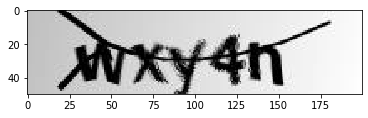

2) the_labels (plate number): wxy4n is encoded as [16, 17, 18, 2, 14]
3) input_length (width of image that is fed to the loss function): 48 == 200 / 4 - 2
4) label_length (length of plate number): 5


In [60]:
for inp, out in tiger.next_batch():
    print('Text generator output (data which will be fed into the neutral network):')
    print('1) the_input (image)')
    if K.image_data_format() == 'channels_first':
        img = inp['the_input'][0, 0, :, :]
    else:
        img = inp['the_input'][0, :, :, 0]
    
    plt.imshow(img.T, cmap='gray')
    plt.show()
    print('2) the_labels (plate number): %s is encoded as %s' % 
          (labels_to_text(inp['the_labels'][0]), list(map(int, inp['the_labels'][0]))))
    print('3) input_length (width of image that is fed to the loss function): %d == %d / 4 - 2' % 
          (inp['input_length'][0], tiger.img_w))
    print('4) label_length (length of plate number): %d' % inp['label_length'][0])
    break

# Loss and train functions, network architecture

In [96]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)


def train(img_w, load=False):
    # Input Parameters
    img_h = 50

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 32
    rnn_size = 512

    if K.image_data_format() == 'channels_first':
        input_shape = (1, img_w, img_h)
    else:
        input_shape = (img_w, img_h, 1)
        
    batch_size = 4
    downsample_factor = pool_size ** 2
    tiger_train = TextImageGenerator('./ctc_loss_images/train', 'train', img_w, img_h, batch_size, downsample_factor)
    tiger_train.build_data()
    tiger_val = TextImageGenerator('./ctc_loss_images/val', 'val', img_w, img_h, batch_size, downsample_factor)
    tiger_val.build_data()

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)

    conv_to_rnn_dims = (img_w // (pool_size ** 2), (img_h // (pool_size ** 2)) * conv_filters)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirecitonal GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(tiger_train.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[tiger_train.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int64')
    label_length = Input(name='label_length', shape=[1], dtype='int64')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)

#     if load:
#         model = load_model('./tmp_model.h5', compile=False)
#     else:
    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    
    if not load:
        # captures output of softmax so we can decode the output during visualization
        test_func = K.function([input_data], [y_pred])

        model.fit_generator(generator=tiger_train.next_batch(), 
                            steps_per_epoch=tiger_train.n,
                            epochs=2, 
                            validation_data=tiger_val.next_batch(), 
                            validation_steps=tiger_val.n)

    return model

# Model description and training

Next block will take about 30 minutes.

In [97]:
model = train(200, load=False)

100%|██████████| 833/833 [00:00<00:00, 113069.75it/s]
184it [00:00, 1836.11it/s]

832


832it [00:00, 2158.86it/s]
100%|██████████| 112/112 [00:00<00:00, 80328.67it/s]
49it [00:00, 486.40it/s]

112


112it [00:00, 582.55it/s]


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 200, 50, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 200, 50, 16)  160         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 100, 25, 16)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 100, 25, 16)  2320        max1[0][0]                       
__________________________________________________________________________________________________
max2 (MaxP

# Function to decode neural network output

In [98]:
# For a real OCR application, this should be beam search with a dictionary
# and language model.  For this example, best path is sufficient.

def decode_batch(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(letters):
                outstr += letters[c]
        ret.append(outstr)
    return ret

# Test on validation images

In [106]:
tiger_test = TextImageGenerator('./ctc_loss_images/test', 'test', 200, 50, 4, 4)
tiger_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output
p = 0
for inp_value, _ in tiger_test.next_batch():
    p = p + 1
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: letters[int(x)], label)))
        texts.append(text)
    print('batch',p,'- pred_texts', pred_texts)
    print('batch',p,'- true_texts', texts,'\n')
    if p>5:
        break

100%|██████████| 113/113 [00:00<00:00, 66604.32it/s]
112it [00:00, 1629.26it/s]


112
batch 1 - pred_texts ['npg', 'n5yy5', 'npf', 'n55']
batch 1 - true_texts ['nnp4e', 'nny5e', 'npxb7', 'nw5b2'] 

batch 2 - pred_texts ['nbcd', 'mggwm', 'mwm', 'nxcxx']
batch 2 - true_texts ['nwfde', 'nwg2m', 'nwncn', 'nxc83'] 

batch 3 - pred_texts ['mxm', 'nfcd', 'mnw44', 'nx']
batch 3 - true_texts ['nxcmn', 'nxf2c', 'nxn4f', 'nxx25'] 

batch 4 - pred_texts ['mxxx', 'n3ww', 'n33', 'npx']
batch 4 - true_texts ['nxxf8', 'ny3dw', 'ny3nn', 'ny5dp'] 

batch 5 - pred_texts ['n5np', 'n5xx', 'ng', '7ggy7']
batch 5 - true_texts ['ny8np', 'nybcx', 'p24gn', 'p2dw7'] 

batch 6 - pred_texts ['npg', 'n2xx', 'nppy2', 'mgg4']
batch 6 - true_texts ['p2m6n', 'p2x7x', 'p2ym2', 'p4nm4'] 

